## Numba + CUDA on Google Colab

By default, Google Colab is not able to run numba + CUDA, because two lilbraries are not found, `libdevice` and `libnvvm.so`. So we need to make sure that these libraries are found in the notebook.  

First, we look for these libraries on the system. To do that, we simply run the `find` command, to recursively look for these libraries starting at the root of the filesystem. The exclamation mark escapes the line so that it's executed by the Linux shell, and not by the jupyter notebook.

In [1]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'


/root/.julia/artifacts/6283886c5dd600750885a23bff8d37f687172633/share/libdevice
find: ‘/proc/66/task/66/net’: Invalid argument
find: ‘/proc/66/net’: Invalid argument
/usr/local/lib/python3.12/dist-packages/nvidia/cuda_nvcc/nvvm/libdevice
/usr/local/cuda-12.5/nvvm/libdevice
find: ‘/proc/66/task/66/net’: Invalid argument
find: ‘/proc/66/net’: Invalid argument
/usr/local/lib/python3.12/dist-packages/nvidia/cuda_nvcc/nvvm/lib64/libnvvm.so
/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so


Then, we add the two libraries to numba environment variables:

In [2]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-12.5/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so"


In [3]:
!uv pip install -q --system numba-cuda==0.4.0

And we're done! Now let's get started.

## A gentle introduction to ufuncs

Numpy universal functions or ufuncs are functions that operate on a numpy array in an element-by-element fashion. For example, when we take the square of a numpy array, a ufunc computes the square of each element before returning the resulting array:  

In [4]:
import numpy as np
x = np.arange(10)
x**2

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

Most math functions (if not all) are available as ufuncs in numpy. For example, to exponentiate all elements in a numpy array:

In [5]:
np.exp(x)

array([1.00000000e+00, 2.71828183e+00, 7.38905610e+00, 2.00855369e+01,
       5.45981500e+01, 1.48413159e+02, 4.03428793e+02, 1.09663316e+03,
       2.98095799e+03, 8.10308393e+03])

Most ufuncs are implemented in compiled C code, so they are already quite fast, and much faster than plain python. For example, let's consider a large array, and let's compute the logarithm of each element, both in plain python and in numpy:

In [6]:
import math
x = np.arange(int(1e6))
%timeit np.sqrt(x)
%timeit [math.sqrt(xx) for xx in x]

1.55 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
132 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that the numpy ufunc is about 50 times faster. Still, in the ufunc, the calculation is not parallelized: the square root is computed sequentially on the CPU for each element in the array.

The GPU, contrary to the CPU, is able to perform a large number of operations simultaneously. In the following, we will see how to create and compile ufuncs for the GPU to perform the calculation on many elements at the same time.

## A very simple example : parallel square root calculation on the GPU

Our first ufunc for the GPU will again compute the square root for a large number of points.

We start by building a sample of points ranging from 0 to 10 millions. GPUs are more efficient with numbers that are encoded on a small number of bits. And often, a very high precision is not needed. So we create a sample of `float32` numbers (the default being `float64`):

In [7]:
import numpy as np
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
npoints = int(1e7)
a = np.arange(npoints, dtype=np.float32)

With numba, we can create ufuncs **compiled for the CPU** using the vectorize decorator. Let's start by doing this:

In [8]:
import math
from numba import vectorize

@vectorize
def cpu_sqrt(x):
  return math.sqrt(x)

cpu_sqrt(x)

array([  0.        ,   1.        ,   1.41421356, ..., 999.9985    ,
       999.999     , 999.9995    ])

Creating a ufunc **for the GPU** is almost as straightforward:

In [9]:
import math
from numba import vectorize

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)


In [10]:
gpu_sqrt(a)

array([0.0000000e+00, 1.0000000e+00, 1.4142135e+00, ..., 3.1622771e+03,
       3.1622773e+03, 3.1622776e+03], dtype=float32)

It is important to note that, contrary to the CPU case, the input and return types of the function have to be specified, when compiling for the GPU. In the string:

```
'float32(float32)'
```

The first `float32` corresponds to the return type, and the second one to the input type. You can think of it as: the returned value is a function of the input value. Also, please note that these types need to be adapted to your data. In the case above, we have created an array of `float32` values, so we are fine.

**Exercise:** Edit the type definition in the vectorize decorator to read `float64`, and see what happens when you call the function. Then change it back to `float32`.

Now let's see how much we gained. For this, we use the timeit magic command.

In [11]:
%timeit gpu_sqrt(a)

27.4 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The GPU managed to compute the sqrt for 10 million points in 40 ms. Now let's see what we get with numpy, which is compiled for the CPU, and with our CPU ufunc:


In [12]:
%timeit np.sqrt(a)

9.82 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit cpu_sqrt(a)

9.69 ms ± 725 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Wait! We do not gain anything and the CPU version is actually twice faster!

There is a simple reason for this. When running on the GPU, the following happens under the hood:

* the input data (the array `a`) is transferred to the GPU memory;
* the calculation of the square root is done in parallel on the GPU for all elements of `a`;
* the resulting array is sent back to the host system.

If the calculation is too simple, there is no use shipping our data to the GPU for fast parallel processing, if we are to wait so long for the data transfers to complete. In other words, most of the time is spent in the data transfers, and the GPU is basically useless.

Let's see what happens with a more involved calculation.



## From cartesian to polar coordinates on the GPU

Let's build an array of 1000 points in 2D, described by the cartesian coordinates x and y. We choose to draw the points according to a 2D Gaussian distribution, introducing some correlation between the x and y components:

In [14]:
points = np.random.multivariate_normal([0,0], [[1.,0.9], [0.9,1.]], 1000).astype(np.float32)

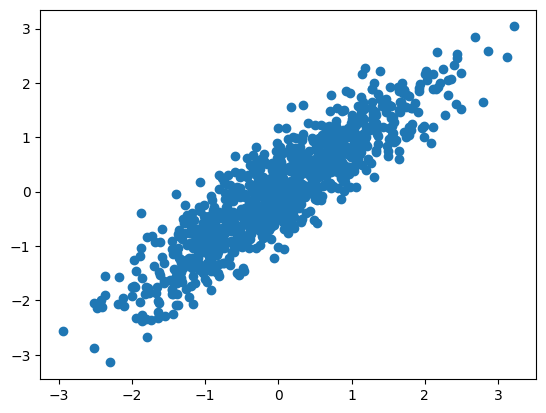

In [15]:
import matplotlib.pyplot as plt
plt.scatter(points[:,0], points[:,1])

It's often useful to convert cartesian coordinates into the polar coordinates `R` and `theta`, where r is the distance of the point to origin, and where theta is the angle between the x axis and the direction of the point.

![](https://raw.githubusercontent.com/cbernet/maldives/master/numba/cart_polar.png)

`R` is easily obtained as the quadratic sum of x and y:

$$R = \sqrt{x^2 + y^2}$$

But to get theta, one has to use the `arctan2` function. This function is available in numpy, and we can use it to easily get the results (please note that the y coordinate has to be provided as the first argument)

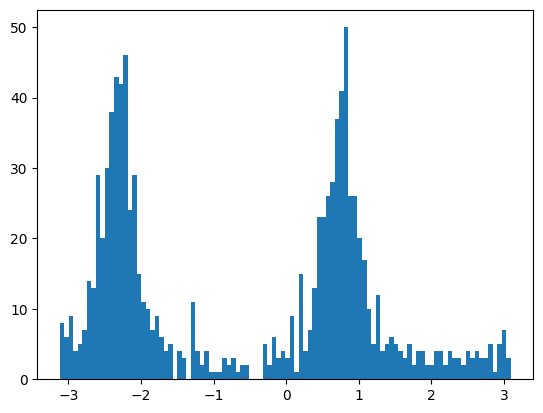

In [16]:
theta = np.arctan2(points[:,1], points[:,0])
_ = plt.hist(theta, bins=100)

Because of the correlation between x and y, we see two peaks at $\pi/4$ and $-3\pi/4$.

Now let's try and perform the same calculation on the GPU. This time, we have two input values, and we define the function signature accordingly.

In [17]:
import math
@vectorize(['float32(float32, float32)'],target='cuda')
def gpu_arctan2(y, x):
    theta = math.atan2(y,x)
    return theta

As before with `np.arctan2`, we need to slice our `points` array to provide first the array of `y` coordinates, and then the array of `x` coordinates:

In [18]:
theta = gpu_arctan2(points[:,1], points[:,0])

ValueError: Array contains non-contiguous buffer and cannot be transferred as a single memory region. Please ensure contiguous buffer with numpy .ascontiguousarray()

Hmm this doesn't work. As the exception says, it is because `points[:,1]` contain values that are not contiguous in memory, and same for `points[:,2]`. So we do as instructed and convert these slices into contiguous arrays:

In [19]:
x = np.ascontiguousarray(points[:,0])
y = np.ascontiguousarray(points[:,1])

In [20]:
theta = gpu_arctan2(y, x)

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


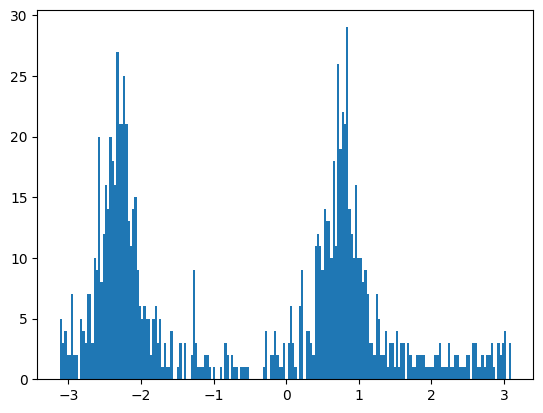

In [21]:
_ = plt.hist(theta, bins=200)

And now it works!

**As a general rule, one should remember that CUDA operates on data buffers that are contiguous in memory, like a C array, or a numpy array before any slicing.**

Now let's be a bit more ambitious, and compute theta for 10 million points:

In [22]:
points = np.random.multivariate_normal([0,0], [[1.,0.9], [0.9,1.]], int(1e7)).astype(np.float32)
x = np.ascontiguousarray(points[:,0])
y = np.ascontiguousarray(points[:,1])

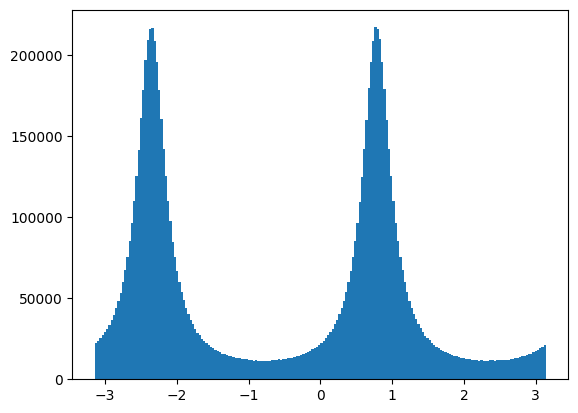

In [23]:
_ = plt.hist(gpu_arctan2(y, x), bins=200)

And finally, let's quantify how much time we gain by running on the GPU:

In [24]:
%timeit gpu_arctan2(y, x) # compiled for the GPU

40.7 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit np.arctan2(y, x) # compiled for the CPU

323 ms ± 7.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit [math.atan2(point[1], point[0]) for point in points] # plain python

5 s ± 382 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Nice! this time we gain almost a factor 10 on the GPU with respect to the numpy version, which is compiled for the CPU. And this comes on top of a factor 20 gain with respect to plain python.

**Remember: To use the GPU efficiently, you need to give it enough data to process, and complicated tasks.**

## Generalized ufuncs on the GPU

In regular ufuncs, the calculation is done on each element of the input array, and returns a scalar.

In generalized ufuncs (gufuncs), however, the calculation can deal with a sub-array of the input array, and return an array of different dimensions.

Ok, I know that sometimes what I write does not make sense... But at least I realize it! So let's have a look at a few examples, things are going to become much clearer.

### Generalized ufuncs : from cartesian to polar coordinates

Remember how we computed the polar angle for our 2D points above? It would have been nice to get both rho and theta from this calculation, to get a real conversion from cartesian to polar coordinates. This kind of thing is not possible with regular ufuncs (or maybe I just don't know how to do it). But with gufuncs, it's easy:

In [27]:
from numba import guvectorize

@guvectorize(['(float32[:], float32[:])'],
             '(i)->(i)',
             target='cuda')
def gpu_polar(vec, out):
    x = vec[0]
    y = vec[1]
    out[0] = math.sqrt(x**2 + y**2)
    out[1] = math.atan2(y,x)


There are two imporant differences between `guvectorize` and `vectorize`.

For `guvectorize`:

* **one needs to provide the signature of the array operation**. The signature of the array operation should not to confused with the signature of the compiled function that is provided as a first argument. In the example above, `(i)->(i)` means that a 1D array is taken in input, and that a 1D array with the same size is provided in the output. The 1D array corresponds to the last dimension or innermost dimension of the input array. For example, our points array is of shape `(10000000,2)` so the last dimension is of size 2.
* **the result is taken in input and modified in place**. In the code above, the resulting polar coordinates R and theta are stored in the `out` array while `vec`, the input array, contains the cartesian coordinates `x` and `y`.

Let's do the conversion between cartesian and polar coordinates:




In [28]:
polar_coords = gpu_polar(points)

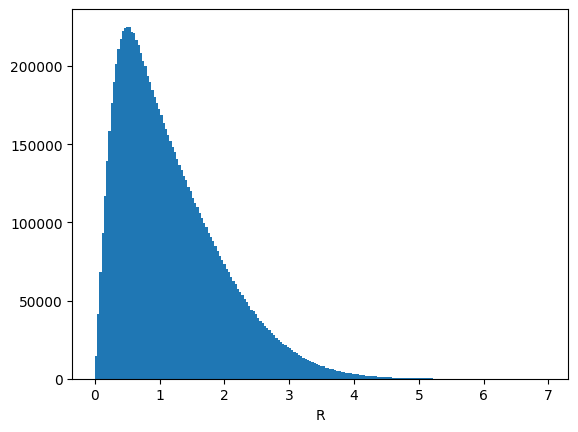

In [29]:
_ = plt.hist(polar_coords[:,0], bins=200)
_ = plt.xlabel('R')

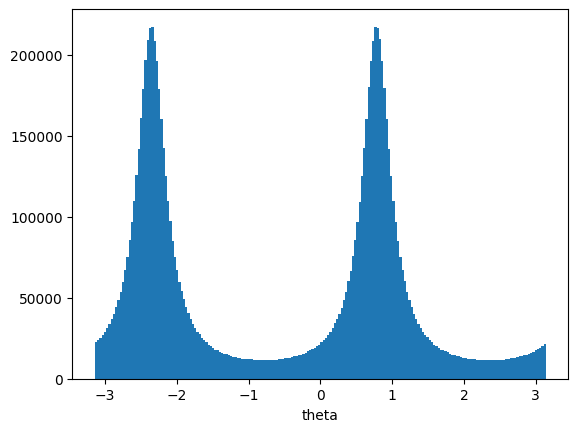

In [30]:
_ = plt.hist(polar_coords[:,1], bins=200)
_ = plt.xlabel('theta')

### Generalized ufunc: Average

To understand better how gufuncs work, let's make one that computes the average of the values on each line of a 2D array:

In [31]:
@guvectorize(['(float32[:], float32[:])'],
             '(n)->()',
             target='cuda')
def gpu_average(array, out):
    acc = 0
    for val in array:
        acc += val
    out[0] = acc/len(array)

To test our gufunc, we create a 2D array:

In [32]:
a = np.arange(100).reshape(20, 5).astype(np.float32)
a

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14.],
       [15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34.],
       [35., 36., 37., 38., 39.],
       [40., 41., 42., 43., 44.],
       [45., 46., 47., 48., 49.],
       [50., 51., 52., 53., 54.],
       [55., 56., 57., 58., 59.],
       [60., 61., 62., 63., 64.],
       [65., 66., 67., 68., 69.],
       [70., 71., 72., 73., 74.],
       [75., 76., 77., 78., 79.],
       [80., 81., 82., 83., 84.],
       [85., 86., 87., 88., 89.],
       [90., 91., 92., 93., 94.],
       [95., 96., 97., 98., 99.]], dtype=float32)

In [33]:
gpu_average(a)

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 2.,  7., 12., 17., 22., 27., 32., 37., 42., 47., 52., 57., 62.,
       67., 72., 77., 82., 87., 92., 97.], dtype=float32)

## Device functions

So far, we have run a single function, either a ufunc or a gufunc, on the GPU, but we are not forced to put all of our code in a single function.

Indeed, it is also  possible to compile helper functions for the GPU. These functions, called **device functions**, can then be used on the GPU to make the code cleaner and more modular.

As an example, let's take again the gufunc defined just above, that computes the average of the values of each line of a 2D array.

We define a device function to add the using the `numba.cuda.jit` decorator, to sum up the elements of a 1D array. Then, we modify the gpu_average gufunc to make use of the `add` device function. And finally, we create another gufunc to sum up the elements of on each line of a 2D array:

In [34]:
from numba import cuda

@cuda.jit(device=True)
def add(array):
  acc = 0
  for val in array:
    acc += val
  return acc

@guvectorize(['(float32[:], float32[:])'],
             '(n)->()',
             target='cuda')
def gpu_average_2(array, out):
    out[0] = add(array)/len(array)

@guvectorize(['(float32[:], float32[:])'],
             '(n)->()',
             target='cuda')
def gpu_sum(array, out):
    out[0] = add(array)



In [35]:
gpu_average_2(a)

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 2.,  7., 12., 17., 22., 27., 32., 37., 42., 47., 52., 57., 62.,
       67., 72., 77., 82., 87., 92., 97.], dtype=float32)

In [36]:
gpu_sum(a)

array([ 10.,  35.,  60.,  85., 110., 135., 160., 185., 210., 235., 260.,
       285., 310., 335., 360., 385., 410., 435., 460., 485.],
      dtype=float32)

The device function allows us to avoid code duplication.

Obviously, it is a bit artifial to use a device function in such an easy case. But when implementing complex algorithms, these functions can prove very useful. Indeed, just like on the CPU, the general principles of programming apply: functions should be simple and to the point, and code duplication should be avoided.

## Memory management with device arrays

As we have seen in the first ufunc example given in this article (parallel square root calculation), the GPU does not always provide a gain in performance.

Indeed, before using the raw computing power of the GPU, we need to ship the data to the device. And afterwards, we need to get the results back.

A good way to improve performance is to minimize data transfers between the host system and the GPU,  and this can be done with device arrays.

To illustrate this, we will use an example provided by nvidia in its DLI course. Let's assume we want to implement a neural network for image processing from scratch. A hidden layer in the network might have to do the following:

* normalize greyscale values in the image
* weigh them
* apply an activation function

Each of these three tasks can be done in parallel on the GPU.

But first, let's see how to do that on the CPU with plain numpy.
For simplicity, we will generate the greyscale values and the weights randomly.

In [37]:
n = 1000000

# random values between 0. and 255.
greyscales = np.floor(np.random.uniform(0, 256, n).astype(np.float32))
# random weights following a Gaussian distribution
# centred on 0.5 and with width 0.1
weights = np.random.normal(.5, .1, n).astype(np.float32)

def normalize(grayscales):
    return grayscales / 255

def weigh(values, weights):
    return values * weights

def activate(values):
    return ( np.exp(values) - np.exp(-values) ) / \
            ( np.exp(values) + np.exp(-values) )



In [38]:
%%timeit
normalized = normalize(greyscales)
weighted = weigh(normalized, weights)
activated = activate(weighted)

8.74 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now, we implement a parallel version of this algorithm for the GPU, as we have seen above.

In [39]:
@vectorize(['float32(float32)'],target='cuda')
def gpu_normalize(x):
  return x / 255

@vectorize(['float32(float32, float32)'],target='cuda')
def gpu_weigh(x, w):
  return x * w

@vectorize(['float32(float32)'],target='cuda')
def gpu_activate(x):
  return ( math.exp(x) - math.exp(-x) ) / ( math.exp(x) + math.exp(-x) )



Please note that the code in these ufuncs operates on scalar values, so we replaced the numpy ufuncs like np.exp by their math equivalent (the division by 255 and the multiplication between the values and the weights were also numpy ufuncs, though hidden a bit).

And we check the performance:

In [40]:
%%timeit
normalized = gpu_normalize(greyscales)
weighted = gpu_weigh(normalized, weights)
activated = gpu_activate(weighted)

10.7 ms ± 517 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's already quite nice, we gained more than a factor of two!

But we realize that we spend time transferring data back and forth between the host and the GPU for nothing:

1. transfer `greyscales` to the GPU
1. transfer `normalized` to the host, and then back to the GPU, together with `weights`
1. transfer `weighted` to the host, and then back to the GPU
1. transfer `activated` to the host

Actually, we only need to:

1. transfer `greyscales` and `weights` to the GPU
1. retrieve `activated`

So let's do that:

In [41]:
%%timeit

# create intermediate arrays on the GPU
normalized_gpu = cuda.device_array(shape=(n,),
                               dtype=np.float32)
weighted_gpu = cuda.device_array(shape=(n,),
                             dtype=np.float32)

# note that output device arrays are provided as arguments
gpu_normalize(greyscales, out=normalized_gpu)
gpu_weigh(normalized_gpu, weights, out=weighted_gpu)
activated = gpu_activate(weighted_gpu)

4.53 ms ± 80.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We gain a factor of two by eliminating unnecessary data transfers!

Another important thing to know is that we can also take full control on the transfers to and from the GPU like this:

In [42]:
# transfer inputs to the gpu
greyscales_gpu = cuda.to_device(greyscales)
weights_gpu = cuda.to_device(weights)

# create intermediate arrays and output array on the GPU
normalized_gpu = cuda.device_array(shape=(n,),
                               dtype=np.float32)
weighted_gpu = cuda.device_array(shape=(n,),
                             dtype=np.float32)
activated_gpu = cuda.device_array(shape=(n,),
                             dtype=np.float32)


Now that everything we need is on the GPU, we do the calculation:

In [43]:
%%timeit
gpu_normalize(greyscales_gpu, out=normalized_gpu)
gpu_weigh(normalized_gpu, weights_gpu, out=weighted_gpu)
gpu_activate(weighted_gpu, out=activated_gpu)

489 µs ± 8.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


You might be thinking that this factor 5 gain is artificial, because we did not include the necessary transfer times for the input and output data. That's right! Still, this illustrates how you can take full control of your data transfers, which might prove useful on more complex processing workflows.

For instance, if we wanted to re-use any of the device arrays defined above, we could do it now, as they are still residing on the GPU as I'm writing this!

Finally, here is how to retrieve the results:

In [44]:
activated = activated_gpu.copy_to_host()
activated

array([0.13024612, 0.20219502, 0.5028621 , ..., 0.18503962, 0.24662548,
       0.1528847 ], dtype=float32)